In [21]:
from lib.controller import Controller
from lib.automation import FileDetector
from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.TSV import RegionExporter
from lib.file.pickle import Pickler
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from scipy import stats
import time
import os
import cv2
from lib.utilities import *

In [22]:
dir_base = "C:/Users/jjudge3/Desktop/Data/"
# dir_base = "C:/Users/jjudge3/Desktop/Data/Kate's/"
date = '08-19-22'
data_dir = dir_base + date +"/"
camera_program = 4

quick_test = False

slice_target = [1,2]
rec_target = [i for i in range(0,13)] 
tbs_recording_no = 5
if date == '07-15-22':
    rec_target = [i for i in range(0,17)]  # 7/15
    tbs_recording_no = 5
if date == '07-22-22' and slice_target == 1:
    rec_target = [i for i in range(0,18)]  # 7/19
    tbs_recording_no = 4
if date == '07-22-22' and slice_target == 2:
    rec_target = [i for i in range(0,16)]  
    tbs_recording_no = 5
if date == '07-26-22' and slice_target == 1:
    rec_target = [i for i in range(0,19)]  
    tbs_recording_no = 6
if date == '07-26-22' and slice_target == 2:
    rec_target = [i for i in range(0,16)]  
    tbs_recording_no = 4
if date == '08-01-22':
    slice_target = [1,2]
    rec_target = [i for i in range(11)]  
    tbs_recording_no = 4
if date == "11-30-21":
    rec_target = [2]
if date == "08-19-22":
    slice_target = [1,2]
    rec_target = [i for i in range(1,13)] 
if date == "08-22-22":
    slice_target = [1,2,3,4]
    rec_target = [i for i in range(1,6)] 
if date == "09-01-22":
    slice_target = [i for i in range(1,8)]
    rec_target = [i for i in range(0,7)] 
if date == "06-21-22":
    slice_target = [1,2,3]
    rec_target = [i for i in range(1,10)] 


load_dic = False
enable_alignment = False
align_only_first_rec = True  # instead of asking for a separate alignment for each recording
num_regions_to_export = 5  # max number of regions per record to export to PhotoZ
process_all = False  # overrides slice/rec target to process all files

time_course_types = ['Max', 'Avg', 'Num ROIs', 'df/f']
time_course_choice = 2  # index

# recording schedule
int_trial = 10
num_trial = 5
int_recording = 45
stim_times = 100  # pts
measure_window = [101, 121] # pts

actual_int_recording = int_trial * num_trial + int_recording

#cluster settings
sampling_size = 100000
if quick_test:
    sampling_size = 10000
k_cluster = 95  # set to None for AIC elbow plotting
# cluster filter settings
n_pixel_cutoff = 3  # maximum cluster size allowed
average_snr_cutoff_percentile = 50  # cluster-specific percentile

if quick_test:
    k_cluster = 5
    slice_target = [slice_target[0]]
    rec_target = rec_target[0:3]

# save time loading and clustering data by loading a saved run
save = True
restore_pickle = None  # saved run index to load, or None. 
save_pickle_index = 0  # save run index to save, or None. Will find higher index to avoid overwrite
if not save:  # then load
    restore_pickle, save_pickle_index = save_pickle_index, restore_pickle

In [23]:
# read in 8-bit single TIF images to array, apply same cropping/binning
single_images = {}
dic_dir = data_dir + "dic/"
cam_settings = CameraSettings().get_program_settings(camera_program)
binning = int(2048 / 80) # if want size similar to RLI

if load_dic and restore_pickle is None:
    TIFLoader(dic_dir, cam_settings, binning, crop=False, flip_horiz=True).load_files(single_images, slice_target=slice_target[0])
    print(list(single_images[slice_target[0]].values())[0]['i'].shape)

slice 1 , rec 1


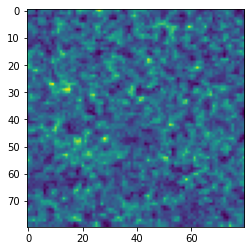

slice 1 , rec 2


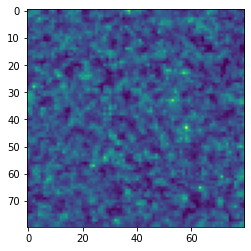

slice 1 , rec 3


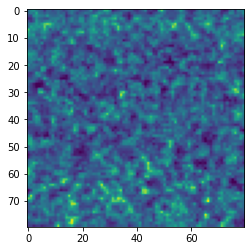

slice 1 , rec 4


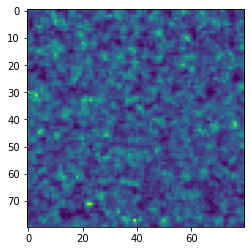

slice 1 , rec 5


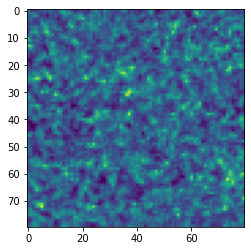

slice 1 , rec 6


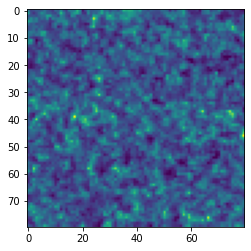

slice 1 , rec 7


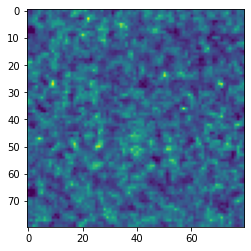

slice 1 , rec 8


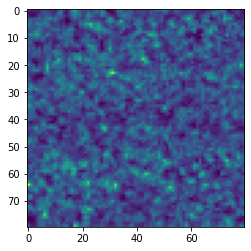

slice 1 , rec 9


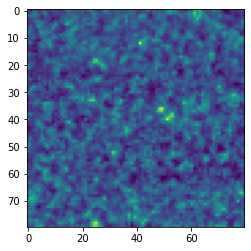

slice 1 , rec 10


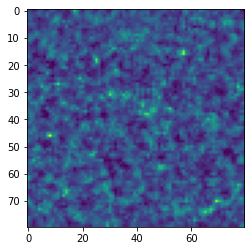

slice 1 , rec 11


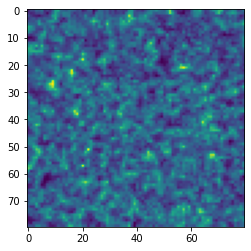

slice 1 , rec 12


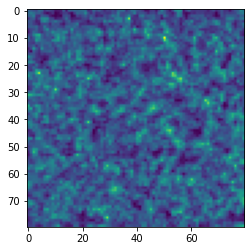

slice 2 , rec 1


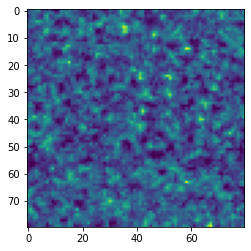

slice 2 , rec 2


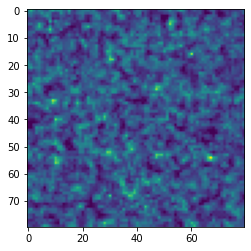

slice 2 , rec 3


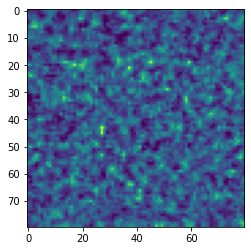

slice 2 , rec 4


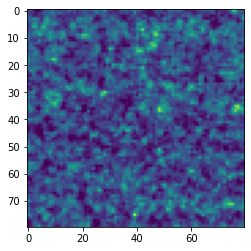

slice 2 , rec 5


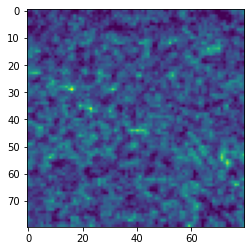

slice 2 , rec 6


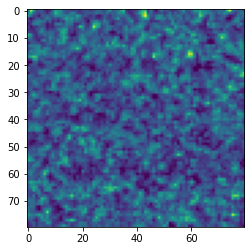

In [24]:
# read in non-normalized maps exported from PhotoZ: 
#  pre-stim SNR, stim SNR, RLI, and stim MaxAmp (DAT files)
dat_dir = data_dir + "converted_zda/"
if restore_pickle is None:
    for filename in os.listdir(dat_dir):
        if (filename.endswith(".dat") or filename.endswith(".txt")) and filename[:3] != "ROI":
            if filename.startswith("traces"):
                continue  # skip these files, they are trace dats
            map_type = filename[:3]
            name_parse = filename.split('.')[0][-8:]
            try:
                slic, loc, rec = [int(x) for x in name_parse.split('_')]
            except ValueError:
                continue
            if slic not in single_images:
                single_images[slic] = {}
            if loc not in single_images[slic]:
                single_images[slic][loc] = {}
            if map_type not in single_images[slic][loc]:
                single_images[slic][loc][map_type] = {}
            dat = np.loadtxt(dat_dir + filename,
                             delimiter='\t',
                             usecols=(1,))
            width = int(np.sqrt(dat.shape[0]))
            dat = dat.reshape((width, width))
            if map_type == "SNR" and slic in slice_target and rec in rec_target:
                print("slice", slic, ", rec", rec)
                plt.imshow(dat)
                plt.show()
            single_images[slic][loc][map_type][rec] = {
                'data': dat,
                'filename': filename}


In [25]:
# align RLI and DIC and record the RLI's image boundaries within the DIC image.
img_aligner = ImageAlign()
if enable_alignment:

    for slic in single_images:
        for loc in single_images[slic]:

            # DICs
            fluor = single_images[slic][loc]['f']
            # img = single_images[slic][loc]['i']
            dic_electrode = single_images[slic][loc]['e']
            dic_electrode = np.array(dic_electrode, dtype=np.uint8)
            
            if len(single_images[slic][loc]['SNR'].keys()) > 0:
                # ask user to trace out shape of electrode (and/or other features)
                dic_electrode = np.array(img_aligner.draw_on_image(dic_electrode))
                plt.imshow(dic_electrode, cmap='gray')
                plt.show()
                first_alignment = None
            
            for rec in single_images[slic][loc]['SNR']:

                if (process_all or (slic in slice_target and rec in rec_target)) and restore_pickle is None:
                    
                    print("\n\n\n *********** Slice", str(slic) + ", Loc", str(loc) + ", Rec", str(rec), "*********** ")
                    
                    if align_only_first_rec and first_alignment is not None:
                        single_images[slic][loc]['RLI'][rec]['alignment'] = first_alignment
                        continue

                    rli = single_images[slic][loc]['RLI'][rec]['data']
                    rli = np.array(rli * 255, dtype=np.uint8)
                    rli = np.array(img_aligner.draw_on_image(rli))
                    plt.imshow(rli, cmap='gray')
                    plt.show()
                    
                    alignment_corners = []
                    
                    # user drags image to align
                    nw_drag_corner = img_aligner.drag_to_align(dic_electrode, rli)
                    print(nw_drag_corner)
                    
                    # store alignment info
                    single_images[slic][loc]['RLI'][rec]['alignment'] = alignment_corners
                    if align_only_first_rec:
                        first_alignment = single_images[slic][loc]['RLI'][rec]['alignment']


In [26]:
roi = ROI_Identifier()
reg_exp = RegionExporter()

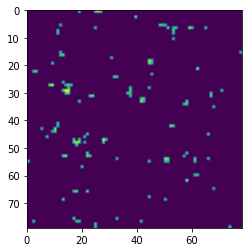

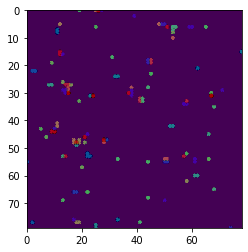

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR01_01_01.dat
***********************







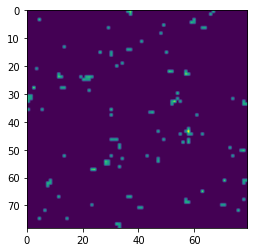

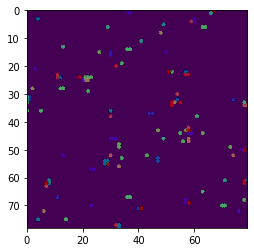

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR01_01_02.dat
***********************







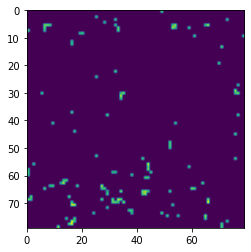

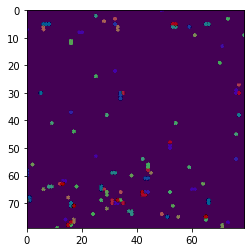

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR01_01_03.dat
***********************







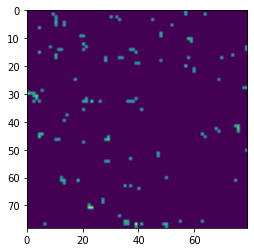

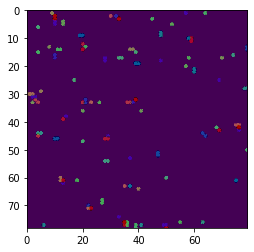

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR01_01_04.dat
***********************







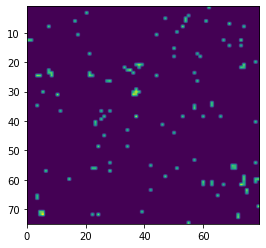

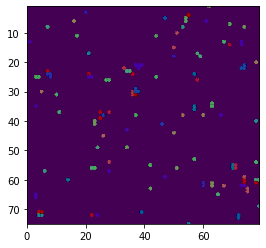

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR01_01_05.dat
***********************







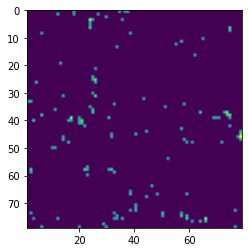

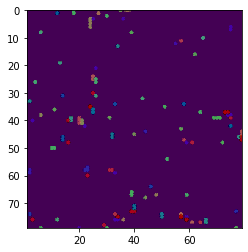

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR01_01_06.dat
***********************







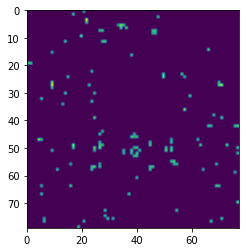

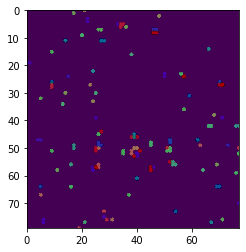

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR01_01_07.dat
***********************







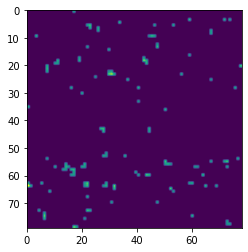

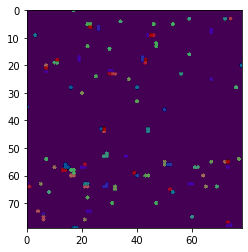

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR01_01_08.dat
***********************







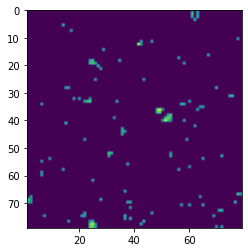

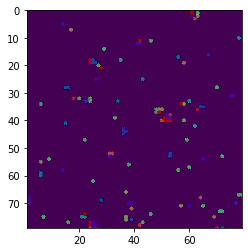

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR01_01_09.dat
***********************







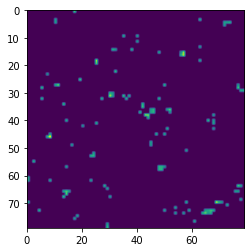

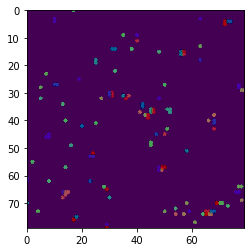

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR01_01_10.dat
***********************







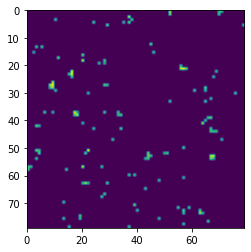

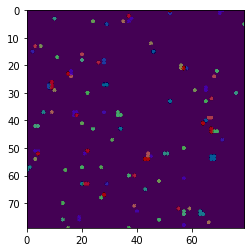

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR01_01_11.dat
***********************







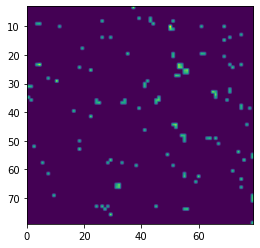

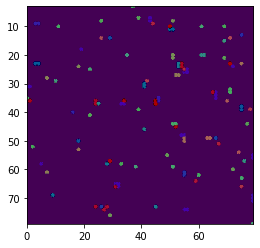

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR01_01_12.dat
***********************







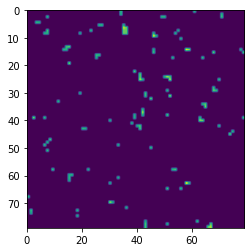

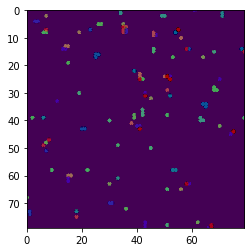

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR02_01_01.dat
***********************







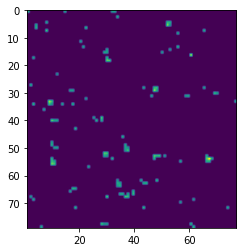

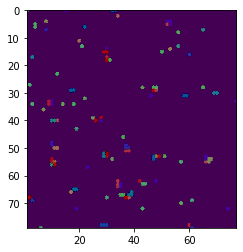

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR02_01_02.dat
***********************







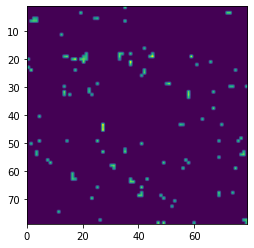

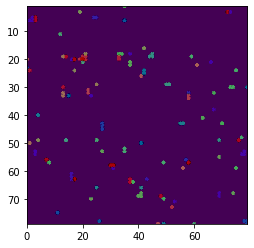

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR02_01_03.dat
***********************







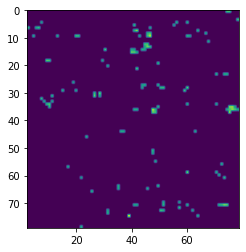

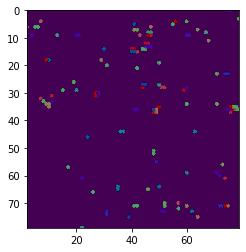

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR02_01_04.dat
***********************







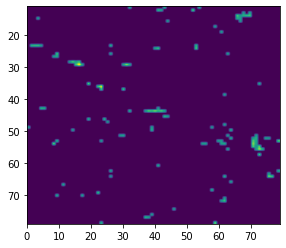

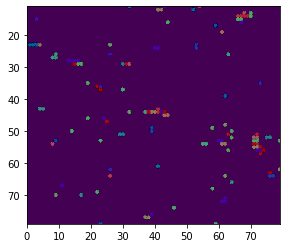

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR02_01_05.dat
***********************







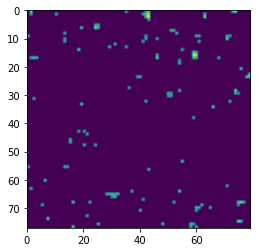

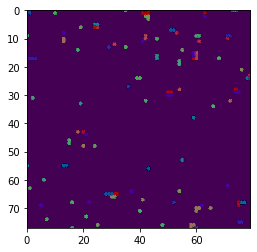

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs98-SNR02_01_06.dat
***********************







In [27]:
# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]

percentile_strata = [ [98, 100]]
if quick_test:
    percentile_strata = [ [95, 100]]


for slic in single_images:
    for loc in single_images[slic]:
        
        # DICs
        #img = single_images[slic][loc]['i']
        #electrode = single_images[slic][loc]['e']
        #fluor = single_images[slic][loc]['f']
        for rec in single_images[slic][loc]['SNR']:
            
            if (process_all or (slic in slice_target and rec in rec_target)) and restore_pickle is None:
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = []

                for stratum in percentile_strata:
                    low_cutoff, hi_cutoff = stratum

                    sampled_points = roi.generate_points(snr, n_points=sampling_size, 
                                                         percentile_cutoff=low_cutoff,
                                                         upper_cutoff=hi_cutoff)

                    roi.heatmap_of_scatter(sampled_points, w, h) # should look similar
                
                    k = k_cluster

                    if k is None:
                        # use AIC and elbow method, then enter choice of k above
                        roi.find_gmm_cluster_number(sampled_points, k_start=30, k_step=10, k_search=91)
                        break
                    else: # after manually selecting k
                        labels = roi.gaussian_mixture_model(sampled_points, k, show=False)

                        roi.draw_gmm_enclosures(sampled_points, labels, a=0.01, s=10)

                        # print ROIs to a DAT file to be loaded into PhotoZ
                        filename = dat_dir + "ROIs" + str(low_cutoff) + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        regions = roi_write.export_clusters(filename, labels, sampled_points, w, limit=num_regions_to_export)
                        
                        print("***********************\n\n\n\n\n")
                        
                        all_regions_by_pixel = roi_write.get_regions_by_pixel()
                        # regions is in format of doubly-nested list of PhotoZ diode numbers

                        cluster_objs = []
                        for px_region in all_regions_by_pixel:
                            cluster_objs.append(Cluster(px_region, w))
                            
                        cluster_strata.append(cluster_objs)
                        single_images[slic][loc]['SNR'][rec]['cluster_strata'] = cluster_strata

In [30]:
# save/load point: pickle all objects to "last run" in current working directory. Also loads if restore_pickle is True
Pickler(dir_base, date, save_pickle_index, restore_pickle, slice_target[0]).process_pickle(single_images)

Wrote: C:/Users/jjudge3/Desktop/Data/08-19-22/saved_run2-1.pickle


In [31]:
for slic in single_images:
    for loc in single_images[slic]:
        print(slic, loc)
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic in slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])
                
                # Split non-contiguous clusters until contiguous
                for stratum in cluster_strata:
                    extra_clusters = []
                    for cluster in stratum:
                        new_clusters = cluster.attempt_split()
                        extra_clusters += new_clusters
                    stratum += extra_clusters
                
                # Filter clusters by size
                for stratum in cluster_strata:
                    for i in range(len(stratum)-1, -1, -1):  # strata 1 is the lower-SNR strata
                        if stratum[i].get_cluster_size() > n_pixel_cutoff:
                            del stratum[i]
                            
                # Filter clusters by avg SNR
                for stratum in cluster_strata:
                    if len(stratum) > 1:
                        stratum_snrs = np.array([cluster.get_cluster_snr(snr) for cluster in stratum])
                        snr_cutoff = np.percentile(stratum_snrs, average_snr_cutoff_percentile)
                        for i in range(len(stratum_snrs)-1, -1, -1):
                            if stratum_snrs[i] < snr_cutoff:
                                del stratum[i]

                # filter adjacent (touching) clusters of different clusters -- remove the lower-SNR one. 
                for i in range(len(cluster_strata)):
                    stratum1 = cluster_strata[i]
                    for j in range(i+1, len(cluster_strata)):
                        stratum2 = cluster_strata[j]
                        for ic_1 in range(len(stratum1)-1, -1, -1):  # stratum 1 is the lower-SNR stratum
                            for c2 in stratum2:
                                if stratum1[ic_1].is_adjacent_to(c2):
                                    del stratum1[ic_1]
                                    break
                                    
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])


1 1
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [60]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [59]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [60]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [63]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [60]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [60]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [60]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [60]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [58]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [61]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [57]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [60]
2 1
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [58]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [58]
Strata sizes (# clusters): [95]
Strata sizes (# clusters): [56]
Strata sizes (# clusters): [95]


No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR01_01_01.dat
2


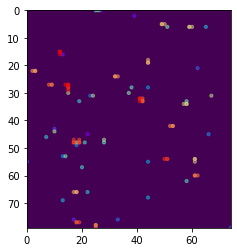

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR01_01_02.dat
2


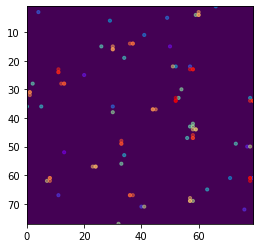

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR01_01_03.dat
2


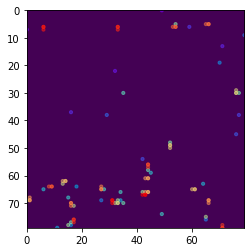

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR01_01_04.dat
2


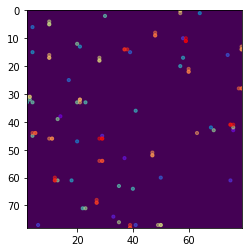

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR01_01_05.dat
2


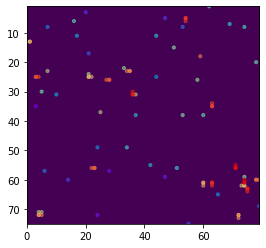

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR01_01_06.dat
2


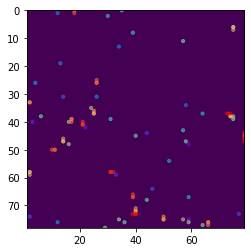

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR01_01_07.dat
2


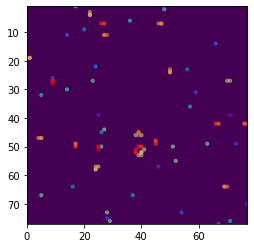

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR01_01_08.dat
2


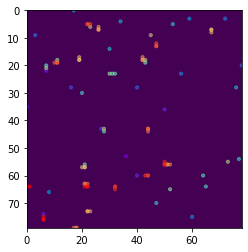

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR01_01_09.dat
2


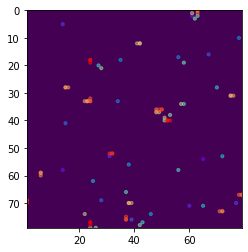

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR01_01_10.dat
2


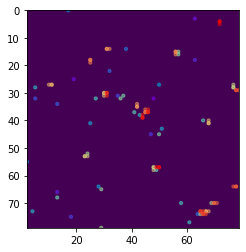

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR01_01_11.dat
2


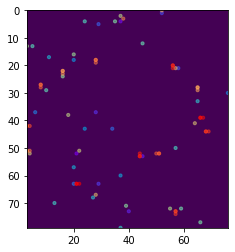

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR01_01_12.dat
2


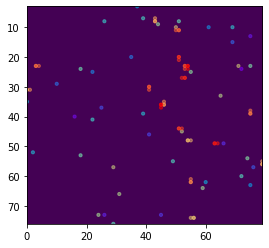

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR02_01_01.dat
2


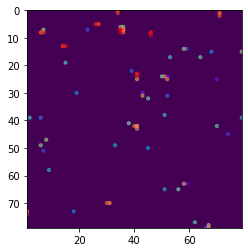

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR02_01_02.dat
2


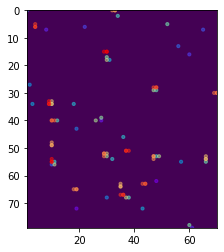

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR02_01_03.dat
2


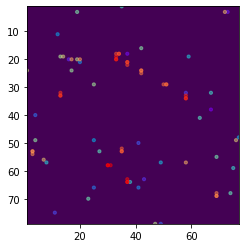

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR02_01_04.dat
2


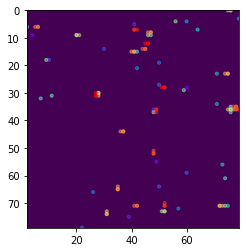

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR02_01_05.dat
2


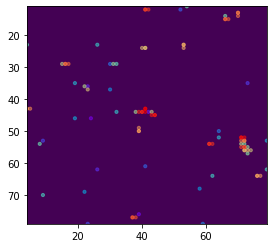

No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs-highest-SNR02_01_06.dat
2


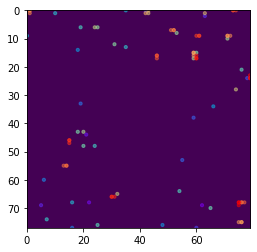

In [32]:
for slic in single_images:
    for loc in single_images[slic]:
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic in slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                                                    
                # consolidate strata and show all surviving ROIs
                plt.clf()
                j_label = 0
                for i in range(len(cluster_strata)):
                    stratum = cluster_strata[i]
                    if len(stratum) > 0:
                        pixels = []
                        labels = []
                        for c in stratum:
                            new_pixels = c.get_pixels()
                            pixels += new_pixels
                            labels += [j_label for _ in range(len(new_pixels))]
                            j_label += 1
                        pixels = np.array(pixels)
                        rli_image = None
                        try:
                            single_images[slic][loc]['RLI'][rec]['data']
                        except Exception as e:
                            print("No RLI image to lay over")
                        roi.draw_gmm_enclosures(pixels, labels, a=0.5, s=10, 
                                                show=False, 
                                                plot_sample_heatmap=False,
                                                overlay_image=rli_image)
                        filename = dat_dir + "ROIs-highest" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        
                        # export only the highest SNR clusters.
                        regions = roi_write.export_clusters(filename, labels, pixels, w, 
                                                            limit=num_regions_to_export,
                                                            snr=snr)

                        # Export ROIs to ImageZ format for region drawing
                        all_px_regions = roi_write.get_regions_by_pixel()
                        filename = dat_dir + "ImageZ" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        filename = filename[:-4] + ".tsv"
                        reg_exp.export(filename, all_px_regions)
                        
                        single_images[slic][loc]['SNR'][rec]['final_ROIs'] = all_px_regions
                        single_images[slic][loc]['SNR'][rec]['final_ROIs_filename'] = filename
                    
                plt.show()

In [36]:
# Now load in the trace*.dat files that OrchestraZ has written
tr = Tracer()
plot_threshold = 9999.5
dff_dist = {}
interval = cam_settings['interval_between_samples']
for filename in os.listdir(dat_dir):
    if filename.endswith(".dat") \
        and filename[:3] != "ROI" \
        and filename.startswith("traces") \
        and "highest" in filename:
            print(filename)
            
            traces = TracesDAT(dat_dir + filename).get_data()
            rec_id = filename.split(".")[0].split("-")[-1][3:]
            slice_loc_id = rec_id[:5]
            if slice_loc_id not in dff_dist:
                dff_dist[slice_loc_id] = []
            mx, my = measure_window
            for roi_name in traces:

                # Measure df of every trace 
                meas = traces[roi_name][mx:my]
                sd = np.std(meas)
                maxx = np.max(meas)
                baseline = np.average(traces[roi_name][10:stim_times-5])
                
                dff = (maxx-baseline) # / rli, already divided in photoZ
                dff_dist[slice_loc_id].append(dff)
                
                # snr = maxx / sd
                
                if dff > plot_threshold:
                    tr.plot_roi_trace(traces[roi_name], 
                                      interval,
                                      rec_id + ": " + roi_name,
                                      stim_time=stim_times,
                                      measure_window=measure_window,
                                      dff=dff)
                else:
                    print(dff)
            
            print('\n\n')


traces_ROIs-highest-SNR01_01_01.dat
1.0982777232941177
1.0119089265882353
2.0603485701058823
0.8072050595294118
1.4621360427058825



traces_ROIs-highest-SNR01_01_02.dat
1.370639188235294
1.1939166570588233
1.3513510465882352
1.0982167268235294
1.247531214



traces_ROIs-highest-SNR01_01_03.dat
0.8906921311764705
1.121006286117647
1.4389917988235295
1.00228484
1.8517944210588235



traces_ROIs-highest-SNR01_01_04.dat
1.9299738181176471
1.4380977447058823
1.5580513792588235
1.5267851964705883
1.5202367447058824



traces_ROIs-highest-SNR01_01_05.dat
1.601840155035294
1.7238503247058823
1.641954198117647
1.7497837070588236
1.8674876634117648



traces_ROIs-highest-SNR01_01_06.dat
2.1687875364705884
1.7616024647058823
2.6284833590588237
1.8428276788235294
1.8207861010588235



traces_ROIs-highest-SNR01_01_07.dat
2.3113475423529413
2.030521697294118
1.313864680352941
1.541045508352941
2.0541122611764706



traces_ROIs-highest-SNR01_01_08.dat
2.4642630092941173
2.3533418696
1.71315306
1.931

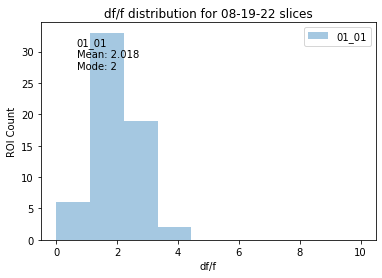

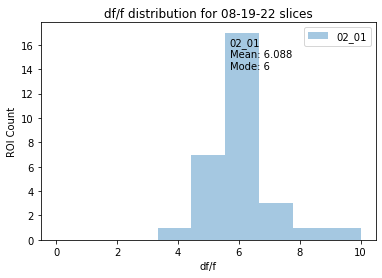

printing Mean averaged over all ROIs for each slice/loc, and # rois
| | 01_01 | 2.018 | 60
| | 02_01 | 6.088 | 30


In [37]:
# Plot df/f distributions for each slice/loc
i = 0
labels = []
for sl_id in dff_dist:
    
    plt.hist(dff_dist[sl_id], 
             np.linspace(0,10,10), 
             alpha=0.4, 
             label=sl_id)
    
    mode = stats.mode([int(np.round(x)) for x in dff_dist[sl_id]])[0][0]
    plt.annotate(sl_id +
               "\nMean: " + str(np.average(dff_dist[sl_id]))[:5]
             + "\nMode: " + str(mode),
               (0.2 + (i%2) * 0.4, 0.75),
                xycoords='figure fraction')
    labels.append(sl_id)
    i += 1
    if i % 2 == 0 or i >= len(dff_dist.keys()) - 1:
        plt.legend(labels)
        plt.title("df/f distribution for " + date + " slices")
        plt.xlabel("df/f")
        plt.ylabel("ROI Count")
        plt.show()
        labels = []
        
print("printing Mean averaged over all ROIs for each slice/loc, and # rois")
for sl_id in dff_dist:
    print("| | " + sl_id + " | " + str(np.average(dff_dist[sl_id]))[:5] + 
         " | " + str(len(dff_dist[sl_id])))


In [35]:
plt.clf()

<Figure size 432x288 with 0 Axes>